In [2]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [1.0, 338.0, 1.0, 404.0, 0.0, 382.0, 2.0, 436.0, 1.0, 416.0, 1.0, 385.0, 0.0, 393.0]
caps:  [1.0, 338.0, 1.0, 404.0, 0.0, 382.0, 2.0, 436.0, 1.0, 416.0, 1.0, 385.0, 0.0, 393.0]
boxes:  [31.0, 29.0, 42.0, 44.0, 36.0, 30.0, 36.0]
medians:  [67.0, 78.0, 86.0, 90.0, 81.0, 70.0, 81.0]
means:  [155.92442182001005, 158.88481403767668, 169.4802347370429, 182.92806347534076, 208.83867942434156, 179.28833430742256, 157.75941854877462]
fliers:  []


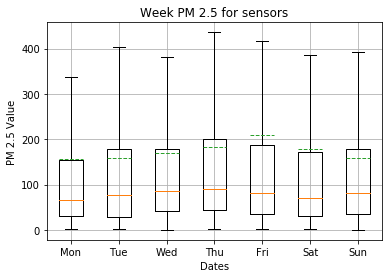

In [41]:
# This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')].between_time('15:00:00', '01:00:00')['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday'].between_time('15:00:00', '01:00:00')['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday'].between_time('15:00:00', '01:00:00')['pm2_5']
thursday = data[data.index.day_name() == 'Thursday'].between_time('15:00:00', '01:00:00')['pm2_5']
friday = data[data.index.day_name() == 'Friday'].between_time('15:00:00', '01:00:00')['pm2_5']
saturday = data[data.index.day_name() == 'Saturday'].between_time('15:00:00', '01:00:00')['pm2_5']
sunday = data[data.index.day_name() == 'Sunday'].between_time('15:00:00', '01:00:00')['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./weely_hybrid_day_boxplot_pm_2_5/weely_hybrid_day_boxplot_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [0.0, 180.0, 0.0, 198.0, 0.0, 220.0, 0.0, 176.0, 0.0, 283.0, 0.0, 205.0, 0.0, 212.0]
caps:  [0.0, 180.0, 0.0, 198.0, 0.0, 220.0, 0.0, 176.0, 0.0, 283.0, 0.0, 205.0, 0.0, 212.0]
boxes:  [15.0, 11.0, 18.0, 24.0, 18.0, 10.0, 10.0]
medians:  [36.0, 38.0, 41.0, 44.0, 49.0, 28.0, 41.0]
means:  [88.67698344271814, 94.70501197551673, 99.88380365188523, 99.57356279006741, 116.1933871116155, 83.36131563650456, 114.86036558953478]
fliers:  []


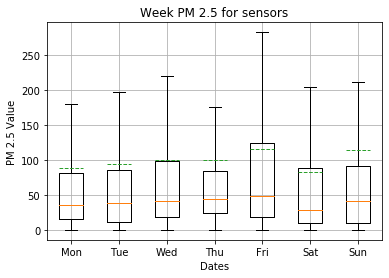

In [42]:
# This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

# data.tz_localize('UTC', level=8)

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')].between_time('01:01', '07:59')['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday'].between_time('01:01', '07:59')['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday'].between_time('01:01', '07:59')['pm2_5']
thursday = data[data.index.day_name() == 'Thursday'].between_time('01:01', '07:59')['pm2_5']
friday = data[data.index.day_name() == 'Friday'].between_time('01:01', '07:59')['pm2_5']
saturday = data[data.index.day_name() == 'Saturday'].between_time('01:01', '07:59')['pm2_5']
sunday = data[data.index.day_name() == 'Sunday'].between_time('01:01', '07:59')['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./weely_hybrid_night_boxplot_pm_2_5/weely_hybrid_night_boxplot_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data